In [37]:
import pydicom as dicom
import numpy as np
from skimage import morphology
from scipy import ndimage
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import PIL
import cv2
import math

In [31]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image

def to_grayscale(image):
    image = image.astype(float)
    image = (np.maximum(image,0) / image.max()) * 255.0
    return np.uint8(image)

def dicom_to_tensor(file_path):
    medical_image = dicom.read_file(file_path)
    image = medical_image.pixel_array
    h = str(medical_image.ImagePositionPatient[-1])
    hu_img = transform_to_hu(medical_image, image)
    win_img = window_image(
                hu_img,
                medical_image.WindowCenter, 
                medical_image.WindowWidth
                )
    t = to_grayscale(win_img)
    f, axarr = plt.subplots(1,3, figsize=(15, 15))
    axarr[0].imshow(image, cmap='gray')
    axarr[1].imshow(hu_img, cmap='gray')
    axarr[2].imshow(win_img, cmap='gray')
    
    return torch.tensor(t), str(h)

def denoised_image(file_path, display=False):
    medical_image = dicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)

    brain_image = window_image(
        hu_image,
        medical_image.WindowCenter, 
        medical_image.WindowWidth) 
    
    brain_image = to_grayscale(brain_image)

    segmentation = morphology.dilation(brain_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int64))
    label_count[0] = 0

    mask = labels == label_count.argmax()

    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    masked_image = mask * brain_image

    f, axarr = plt.subplots(1,3, figsize=(15, 15))
    axarr[0].imshow(image, cmap='gray')
    axarr[1].imshow(brain_image, cmap='gray')
    axarr[2].imshow(masked_image, cmap='gray')
    return masked_image

In [42]:
def tilt_correction(file_path):

    image = denoised_image(file_path)

    img = np.uint8(image)
    contours, hier =cv2.findContours (img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask=np.zeros(img.shape, np.uint8)

    # find the biggest contour (c) by the area
    c = max(contours, key = cv2.contourArea)

    (x,y),(MA,ma),angle = cv2.fitEllipse(c)

    cv2.ellipse(img, ((x,y), (MA,ma), angle), color=(0, 255, 0), thickness=2)

    rmajor = max(MA,ma)/2
    if angle > 90:
        angle -= 90
    else:
        angle += 96
    xtop = x + math.cos(math.radians(angle))*rmajor
    ytop = y + math.sin(math.radians(angle))*rmajor
    xbot = x + math.cos(math.radians(angle+180))*rmajor
    ybot = y + math.sin(math.radians(angle+180))*rmajor
    cv2.line(img, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 255, 0), 3)

    M = cv2.getRotationMatrix2D((x, y), angle-90, 1)  #transformation matrix

    img_rot = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC)

    f, axarr = plt.subplots(1,3, figsize=(15, 15))
    axarr[0].imshow(image, cmap='gray')
    axarr[1].imshow(img, cmap='gray')
    axarr[2].imshow(img_rot, cmap='gray')

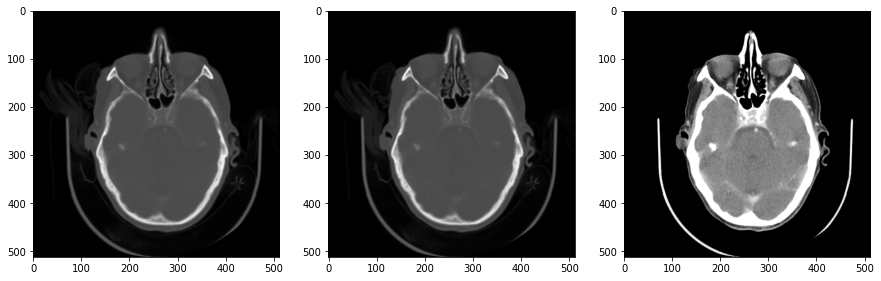

In [30]:
d = dicom_to_tensor("Registered00001.dcm")

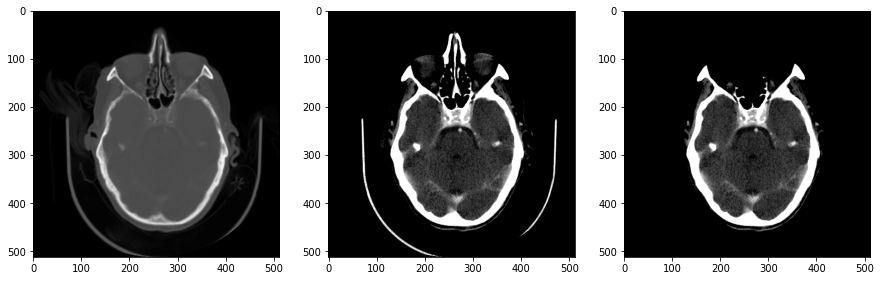

In [32]:
d = denoised_image("Registered00001.dcm")

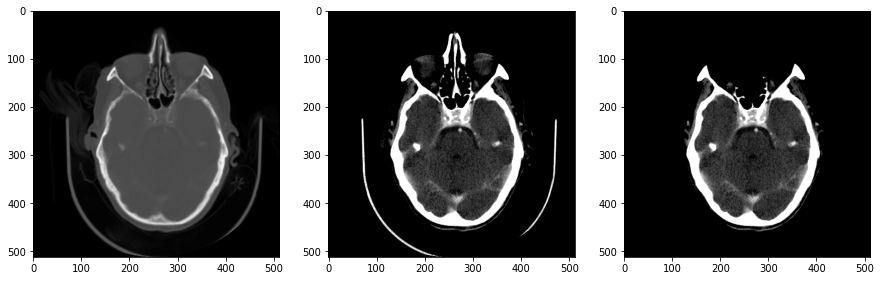

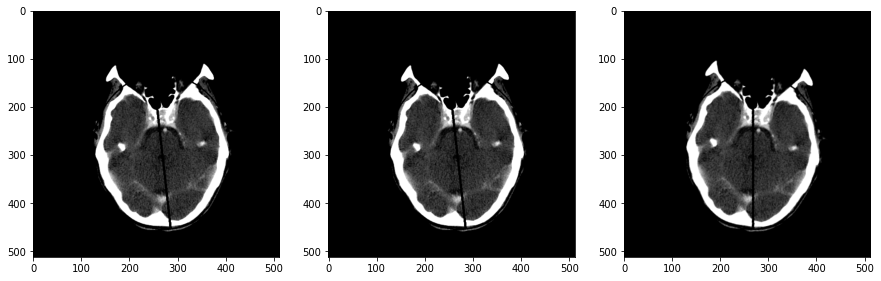

In [43]:
d_rot = tilt_correction("Registered00001.dcm")

In [ ]:
import os
import re
imgs_path = "C:/Users/feder/OneDrive - Università degli Studi di Torino\Documenti/brain/DeepHealth_IEEE"
for pat in os.listdir(imgs_path):
    if re.findall("Registered_Filtered_3mm_20HU", pat) \
        and not re.findall("Registered_Filtered_3mm_20HU_Maps", pat):
        print(pat)

In [ ]:
import os
path = "MOL-003_Registered_Filtered_3mm_20HU"
lst = []
for elem in os.listdir(path):
    medical_image = dicom.read_file(os.path.join(path,elem))
    lst.append(medical_image.ImagePositionPatient[-1])

print(list(set(lst)))

In [ ]:
path = "MOL-003_Registered_Filtered_3mm_20HU_Maps/NLR_CBV"
lst = []
for elem in os.listdir(path):
    medical_image = dicom.read_file(os.path.join(path,elem))
    img, h = dicom_to_tensor(os.path.join(path,elem))
    lst.append()

print(list(set(lst)))

In [ ]:

from collections import defaultdict
img_list = []
im_dict = defaultdict(list)
for element in os.listdir("./"):
    if 'MOL' in element \
        and not '60' in element \
        and not 'MOL-001' in element \
        and not 'MOL-062' in element \
        and not 'MOL-063' in element \
        and not 'MOL-061' in element \
        and not 'Maps' in element:

        for im in os.listdir(element):
            _image = dicom.read_file(os.path.join(element,im))
            h = str(_image.ImagePositionPatient[-1])
            im_dict[h].append(os.path.join(element,im))

        t = torch.zeros((len(im_dict[h]), 512, 512))
        for h in im_dict.keys():
            for i, im_pth in enumerate(im_dict[h]):
                im = dicom_to_tensor(im_pth)
                t[i] = im


        #img_list.append(element)

In [ ]:
for h in im_dict.keys():
    print(h)

In [ ]:
label_list

In [ ]:
label_list[0].split("-")[-1].split("_")[0]

In [ ]:
len(data_list), len(label_list)

In [ ]:
import os, re
from collections import defaultdict

imgs_path = "C:/Users/feder/OneDrive - Università degli Studi di Torino\Documenti/brain/DeepHealth_IEEE"

data_list = []
for p in os.listdir(imgs_path):
    if re.findall("Registered_Filtered_3mm_20HU", p) \
        and not re.findall("Registered_Filtered_3mm_20HU_Maps", p):
        data_list.append(p)

label_list = []
for p in os.listdir(imgs_path):
    if re.findall("Registered_Filtered_3mm_20HU_Maps", p) \
        and not re.findall(".txt", p):
        label_list.append(p)

print(len(data_list), len(label_list))

joint_list = []
for d in data_list:
    for l in label_list:
        if l.split("-")[-1].split("_")[0]==d.split("-")[-1].split("_")[0]:
            joint_list.append([d, l])
joint_list[8]

In [ ]:
def get_data(path):

    im_dict = defaultdict(list)
    for im in os.listdir(path):
        im_path = os.path.join(path,im)
        im_, h = dicom_to_tensor(im_path) 
        im_dict[h].append(im_)
    
    im_list = []
    for h in im_dict.keys():
        t = torch.zeros((len(im_dict[h]), 512, 512))
        for i, im in enumerate(im_dict[h]):
            t[i] = im
        im_list.append(t)
    
    return torch.stack(im_list)
            
        

In [ ]:
import os, re
imgs_path = "C:/Users/feder/OneDrive - Università degli Studi di Torino\Documenti/brain/DeepHealth_IEEE"
type_ = "NLR_CBV"

data_list = []
for p in os.listdir(imgs_path):
    if re.findall("Registered_Filtered_3mm_20HU", p) \
        and not re.findall("Registered_Filtered_3mm_20HU_Maps", p):
        data_list.append(p)

label_list = []
for p in os.listdir(imgs_path):
    if re.findall("Registered_Filtered_3mm_20HU_Maps", p) \
        and not re.findall(".txt", p):
        label_list.append(p)

print(len(data_list), len(label_list))

joint_list = []
for d in data_list:
    for l in label_list:
        if l.split("-")[-1].split("_")[0]==d.split("-")[-1].split("_")[0]:
            joint_list.append((d, l))

print(len(joint_list))

images_list, labels_list = [], []
for d, l in joint_list[7:9]:
    images = get_data(os.path.join(imgs_path, d))
    labels = get_data(os.path.join(imgs_path, l, type_))
    images_list.append(images)
    labels_list.append(labels)
print(images_list[0].shape, labels_list[0].shape)

In [ ]:
print(images_list[0].shape, labels_list[0].shape)

In [ ]:
print(images_list[1].shape, labels_list[1].shape)

In [ ]:
a = torch.cat(images_list)[0]

In [ ]:
spacing = int(np.floor(float(a.size(0))/(89)))
channels = np.arange(0, a.size(0), spacing)[:89]
image_frame = (a[channels,:,:] - 0.2375)/0.3159
image_frame.shape

In [ ]:
spacing = int(np.floor(float(89)/(5)))
channels = np.arange(0, 89, spacing)[:5]
channels

In [ ]:


im_dict = defaultdict(list)
for patient in os.listdir(imgs_path):

    if re.findall("Registered_Filtered_3mm_20HU", patient) \
        and not re.findall("Registered_Filtered_3mm_20HU_Maps", patient):

        for im in os.listdir(os.path.join(imgs_path, patient)):
            im_path = os.path.join(imgs_path,pat,im)
            im_, h = dicom_to_tensor(im_pth) #dicom.read_file(im_path)
            im_dict[h].append(im_)
        
        t = torch.zeros((len(im_dict[h]), 512, 512))
        for h in im_dict.keys():
            for i, im_pth in enumerate(im_dict[h]):
                im = dicom_to_tensor(im_pth)
                t[i] = im



In [ ]:
len(im_dict[h])

In [ ]:
im

In [ ]:
t.min()